# Lab6 - Training Deep Convolutional Neural Network
- Patcharaporn Sirimom, 62070507208

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [1]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate_generator(features,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict_generator(features).argmax(axis=1)
    # labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
def predict_cat_dog(model, directory_file):
    test_filename = os.listdir(directory_file)
    df = pd.DataFrame({
      'filename': test_filename
    })
    plt.figure(figsize=(12, 24))
    for index, row in df.iterrows():
        filename = row['filename']
        img = load_img(directory_file+filename, target_size=IMAGE_SIZE)
        x = image.img_to_array(img)
        x /= 255.0
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        predict = model.predict_generator(images).argmax(axis=1)
        plt.subplot(6, 3, index+1)
        plt.imshow(img)
        if predict == 0:
            plt.xlabel('predict: cat')
        elif predict == 1:
            plt.xlabel('predict: dog')
    plt.tight_layout()
    plt.show()

### 1. Load Cat vs Dog dataset

In [5]:
train_dir = './Cat_Dog_data/train/'
test_dir = './Cat_Dog_data/test/'

In [6]:
BATCH_SIZE = 32

In [7]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

In [8]:
# Cat is 0, Dog is 1
label = []
for file in os.listdir(train_dir):
    labels = file.split('.')[0]
    if labels == 'cat':
        label.append(0)
    else:
        label.append(1)

In [9]:
df = pd.DataFrame({
    'filename':os.listdir(train_dir),
    'class':label
})

In [10]:
df.head()

,filename,class
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [11]:
df.tail()

,filename,class
22495,dog.9994.jpg,1
22496,dog.9995.jpg,1
22497,dog.9997.jpg,1
22498,dog.9998.jpg,1
22499,dog.9999.jpg,1


<AxesSubplot: >

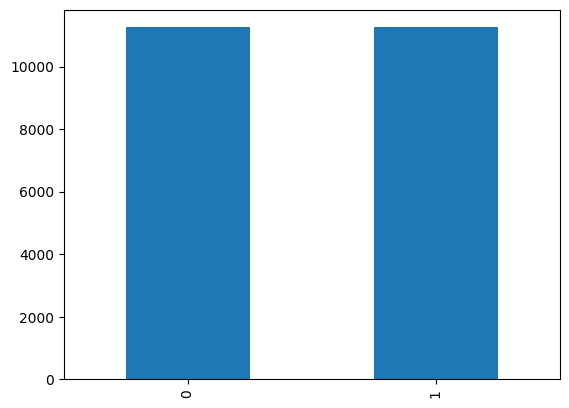

In [12]:
df['class'].value_counts().plot.bar()

In [13]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'}) 

Text(0.5, 1.0, 'cat')

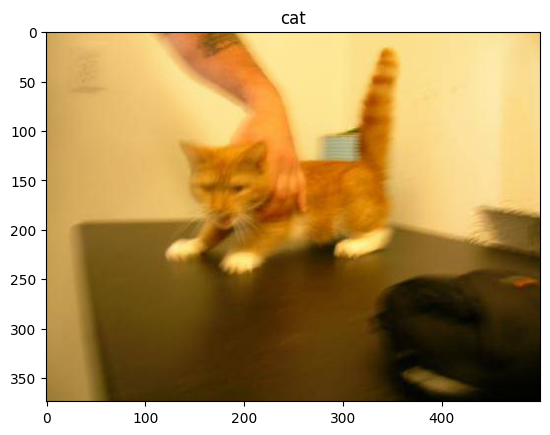

In [14]:
sample = load_img(train_dir+df['filename'][0])
plt.imshow(sample)
plt.title(df['class'][0])

### 3. Train Test Split

In [15]:
### train test split
train_df, validate_df = train_test_split(df, test_size=0.1, random_state=0)

In [16]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [17]:
len(train_df)

20250

In [18]:
train_df.shape[0]

20250

In [19]:
len(validate_df)

2250

### 4. Data preprocessing and Image Augmentation

#### 4.1 Prepare train set and validation set

In [20]:
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

In [21]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                    train_dir,
                                    x_col = 'filename',
                                    y_col = 'class',
                                    target_size=IMAGE_SIZE,
                                    class_mode = 'categorical',
                                    batch_size=BATCH_SIZE)

Found 20250 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                    train_dir,
                                    x_col = 'filename',
                                    y_col = 'class',
                                    target_size=IMAGE_SIZE,
                                    class_mode = 'categorical',
                                    batch_size=BATCH_SIZE)

Found 2250 validated image filenames belonging to 2 classes.


#### 4.2 Prepare test set

In [23]:
# Cat is 0, Dog is 1
label_test = []
for file in os.listdir(test_dir):
    labels = file.split('.')[0]
    if labels == 'cat':
        label_test.append(0)
    else:
        label_test.append(1)

In [24]:
test_df = pd.DataFrame({
    'filename':os.listdir(test_dir),
    'class':label_test
})

In [25]:
test_df["class"] = test_df["class"].replace({0: 'cat', 1: 'dog'}) 

In [26]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [27]:
test_generator = test_datagen.flow_from_dataframe(test_df,
                                    test_dir,
                                    x_col = 'filename',
                                    y_col = 'class',
                                    target_size=IMAGE_SIZE,
                                    batch_size=BATCH_SIZE,
                                    class_mode='categorical',
                                    shuffle=False)

Found 2500 validated image filenames belonging to 2 classes.


In [28]:
test_df

,filename,class
0,cat.10009.jpg,cat
1,cat.10017.jpg,cat
2,cat.10032.jpg,cat
3,cat.10038.jpg,cat
4,cat.10054.jpg,cat
...,...,...
2495,dog.992.jpg,dog
2496,dog.994.jpg,dog
2497,dog.9955.jpg,dog
2498,dog.9972.jpg,dog


### 5. Model building using Transfer Learning (VGG16)

In [30]:
from tensorflow.keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(110,110,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 110, 110, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 110, 110, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 110, 110, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 55, 55, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 55, 55, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 55, 55, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 27, 27, 128)       0     

#### 5.1 Freeze vgg layer (not update weight when training)

In [31]:
for layer in vgg.layers:
    layer.trainable = False

#### 5.2 Connect fully connected with VGG16 model

In [32]:
new_vgg = models.Sequential()
new_vgg.add(vgg)
new_vgg.add(layers.Flatten())
new_vgg.add(layers.Dense(128,activation='relu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))

new_vgg.add(layers.Dropout(0.2,name='dropout_2'))
new_vgg.add(layers.Dense(2,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))

new_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
fully_connect_1 (Dense)      (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 15,304,898
Trainable params: 590,210
Non-trainable params: 14,714,688
_________________________________________________________________


#### Note: I have trainable params is 1,048,962/15,763,650. It help reduce time to train while using imgnet wieght

#### 5.3 Use Adam optimizer and learning rate 1e-4

In [33]:
import tensorflow.keras.optimizers

opt = optimizers.Adam(lr=1e-3)
new_vgg.compile(optimizer=opt,
           loss = 'categorical_crossentropy',
           metrics=['accuracy'])

In [34]:
history_transfer = new_vgg.fit_generator(train_generator,
                           epochs=20,
                           steps_per_epoch=len(train_df) // BATCH_SIZE,
                           validation_data=validation_generator,
                           validation_steps=len(validate_df) // BATCH_SIZE,
                           verbose=1)

C:\Users\babyt\miniconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
632/632 [==============================] - 161s 239ms/step - loss: 0.5300 - accuracy: 0.7252 - val_loss: 0.3224 - val_accuracy: 0.8589
Epoch 2/20
632/632 [==============================] - 131s 207ms/step - loss: 0.4098 - accuracy: 0.8096 - val_loss: 0.2996 - val_accuracy: 0.8728
Epoch 3/20
632/632 [==============================] - 133s 210ms/step - loss: 0.3852 - accuracy: 0.8195 - val_loss: 0.3192 - val_accuracy: 0.8629
Epoch 4/20
632/632 [==============================] - 126s 200ms/step - loss: 0.3820 - accuracy: 0.8263 - val_loss: 0.2846 - val_accuracy: 0.8808
Epoch 5/20
632/632 [==============================] - 132s 209ms/step - loss: 0.3681 - accuracy: 0.8337 - val_loss: 0.2880 - val_accuracy: 0.8813
Epoch 6/20
632/632 [==============================] - 140s 221ms/step - loss: 0.3606 - accuracy: 0.8328 - val_loss: 0.2912 - val_accuracy: 0.8759
Epoch 7/20
632/632 [==============================] - 145s 229ms/step - loss: 0.3562 - accuracy: 0.8381 - val_loss: 0.2779 -

Last train accuracy: 0.8582946062088013
Last validation accuracy: 0.8758928775787354


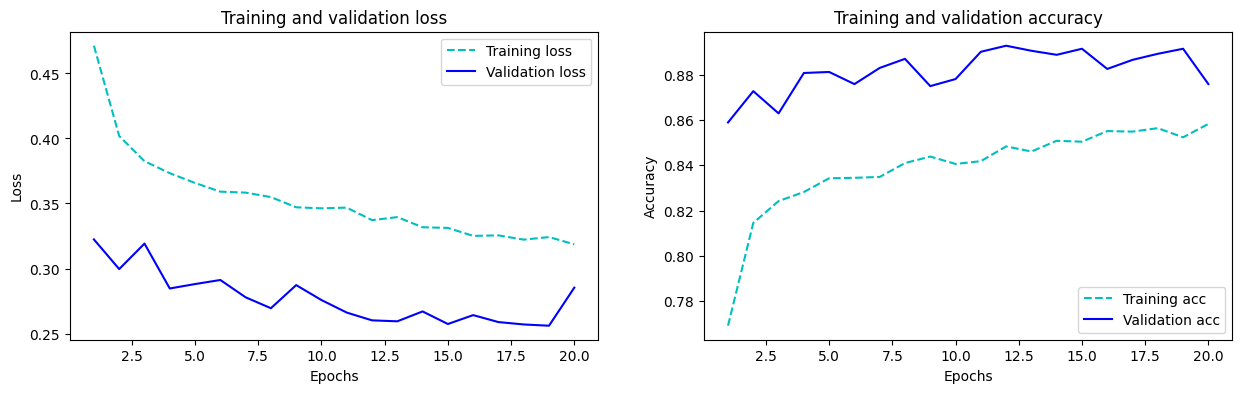

In [38]:
show_result(history_transfer)

### 6. Evaluation

In [39]:
evaluation_report(new_vgg, test_generator, label_test)

C:\Users\babyt\miniconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


KeyboardInterrupt: 

In [37]:
mypic = './test_pet'
predict_cat_dog(new_vgg, mypic)

NameError: name 'mypic' is not defined